In [ ]:
#저장:현재 작업 디렉토리
import os
SAVE_DIR = '.'
current_directory = os.getcwd()
print(current_directory)

/content


##1.모델



In [ ]:
# 필요한 라이브러리
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from collections import defaultdict
from copy import deepcopy
import random

In [ ]:
#데이터셋 준비
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator().manual_seed(SEED)

mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.PILToTensor(),                  # PIL -> Tensor (uint8)
    transforms.ConvertImageDtype(torch.float), # float32 [0,1]
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean, std),
])


trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4,generator=g)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4,generator=g)
print("데이터 준비 완료!")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


데이터 준비 완료!


In [ ]:
#top1,top5 평가함수
def evaluate(model, loader, device):
    model.eval()
    correct1, correct5, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)                          # [B,1000]
            # Top-5 예측 인덱스: [B,5]
            top5 = out.topk(5, dim=1, largest=True, sorted=True).indices
            # Top-1 은 top5[:,0]
            correct1 += (top5[:, 0] == yb).sum().item()
            # Top-5 내에 yb가 있으면
            correct5 += (top5 == yb.unsqueeze(1)).any(dim=1).sum().item()
            total    += yb.size(0)

    top1 = correct1 / total * 100.0
    top5 = correct5 / total * 100.0
    return top1, top5

In [ ]:
#모델 가져오기,summary 기능
from torchvision.models import vgg16_bn
!pip install torchinfo > /dev/null 2>&1
from torchinfo import summary

## 1.실행결과

In [ ]:
# 모델 구조 설정 및 불러온 가중치 넣기, 요약하기
model = vgg16_bn(weights=None)
model.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))
model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(512,100)
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ts_model = torch.jit.load('/content/vgg16bn_cifar100.torchscript.pt', map_location=device)
state_dict = ts_model.state_dict() #state_dict 불러오기

model.load_state_dict(state_dict, strict=False) #새 모델에 가중치 이식
model = model.to(device).eval()

summary(model, input_size=(1,3,32,32), device=str(device))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 100]                  --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 16, 16]          256
│    └─ReLU: 2-10                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-11                      [1, 128, 16, 16]          147,

In [ ]:
#모델 평가 (top1, top5 accuracy)
ts_model.eval()
top1, top5 = evaluate(ts_model, test_loader, device)
print(f"TorchScript Loaded → Top-1: {top1:.2f}%  Top-5: {top5:.2f}%")

TorchScript Loaded → Top-1: 74.94%  Top-5: 91.87%


##2.랭크 계산 함수

In [ ]:
# 필요한 라이브러리
from collections import defaultdict
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
defaultcfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512]
relucfg = [2, 6, 9, 13, 16, 19, 23, 26, 29, 33, 36, 39, 42]
convcfg = [0, 3, 7, 10, 14, 17, 20, 24, 27, 30, 34, 37, 40]

###함수

In [ ]:
class HRankFeatureMapCalculator:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def get_feature_hook(self, layer_name, rank_storage):
        def hook_fn(module, input, output):
            # output: [batch, channels, H, W]
            batch_size = output.shape[0]
            num_channels = output.shape[1]

            # 각 샘플, 각 채널에 대해 rank 계산
            for i in range(batch_size):
                for j in range(num_channels):
                    # 각 채널의 feature map
                    feature_map = output[i, j, :, :]

                #----------------⭐디버깅⭐------------------------#
                    # if j == 1 and i == 0:  # 채널1, 첫 번째 이미지만
                    #   print(f"\n채널1 feature map 샘플 (이미지 {i}):")
                    #   print(feature_map[:5, :5])  # 5x5만 출력
                #----------------⭐디버깅⭐------------------------#

                    # tolerance를 더 크게 설정 (원래 코드 수정)
                    rank = torch.linalg.matrix_rank(
                        feature_map,
                        atol=1e-3,  # ⭐ 원래: 1e-7 → 1e-3으로 증가
                        rtol=1e-2   # ⭐ 원래: 1e-5 → 1e-2로 증가
                    ).item()

                    rank_storage[j].append(rank)

        return hook_fn

    def calculate_ranks_hrank_style(self, dataloader, limit=5):
        self.model.eval()
        all_ranks = {}

        for layer_idx, relu_idx in enumerate(relucfg):
            layer_name = f"conv{layer_idx + 1}"
            relu_module = self.model.features[relu_idx]

            print(f"\n{layer_name} 랭크 계산 중...")

            # 첫 forward pass로 채널 수 확인
            with torch.no_grad():
                sample_input, _ = next(iter(dataloader))
                sample_input = sample_input.to(self.device)

                # 임시 hook으로 채널 수 확인
                temp_output = None
                def temp_hook(m, i, o):
                    nonlocal temp_output
                    temp_output = o

                h = relu_module.register_forward_hook(temp_hook)
                _ = self.model(sample_input)
                h.remove()

                num_channels = temp_output.shape[1]

            # 채널별 rank 저장 리스트 초기화
            rank_storage = {ch: [] for ch in range(num_channels)}

            # Hook 등록
            hook = relu_module.register_forward_hook(
                self.get_feature_hook(layer_name, rank_storage)
            )

            try:
                with torch.no_grad():
                    for batch_idx, (inputs, targets) in enumerate(dataloader):
                        if batch_idx >= limit:
                            break

                        inputs = inputs.to(self.device)
                        _ = self.model(inputs)

                #----------------⭐디버깅⭐------------------------#
                # if layer_idx == 0:  # relucfg에 하나만 있으므로 0번째가 conv10
                #   print(f'\n--conv10 디버깅 (실제 relu_idx={relu_idx})--')
                #   for ch in range(num_channels):
                #     print(f'채널{ch}: {len(rank_storage[ch])}개 랭크가 있음')
                #     if len(rank_storage[ch]) >0:
                #       ranks = rank_storage[ch]
                #       print(f'구한 랭크 처음10개 :{rank_storage[ch][:10]}')
                #       print(f'통계: min={min(rank_storage[ch])},max={max(rank_storage[ch])},평균={np.mean(rank_storage[ch]):.2f}')
                #       print(f'0인 값: {ranks.count(0)}개 / {len(ranks)}개')
                 #----------------⭐디버깅⭐------------------------#

                # 각 채널별 평균 rank 계산
                avg_ranks = []
                for ch in range(num_channels):
                    if len(rank_storage[ch]) > 0:
                        avg_rank = np.mean(rank_storage[ch])
                        avg_ranks.append(avg_rank)
                    else:
                        avg_ranks.append(0.0)

                all_ranks[layer_name] = np.array(avg_ranks)

                print(f"  완료 - 채널 수: {len(avg_ranks)}")
                print(f"  평균 랭크: {np.mean(avg_ranks):.2f}, 범위: {np.min(avg_ranks):.2f}~{np.max(avg_ranks):.2f}")

            finally:
                hook.remove()

        return all_ranks

    def get_layer_info(self, dataloader):
        """각 레이어의 정보 수집"""
        layer_info = {}
        hooks = []
        layer_outputs = {}

        def make_info_hook(layer_name):
            def hook_fn(module, input, output):
                layer_outputs[layer_name] = {
                    'shape': output.shape,
                    'num_channels': output.shape[1],
                    'height': output.shape[2],
                    'width': output.shape[3],
                    'max_possible_rank': min(output.shape[2], output.shape[3])
                }
            return hook_fn

        for layer_idx, relu_idx in enumerate(relucfg):
            layer_name = f"conv{layer_idx + 1}"
            relu_module = self.model.features[relu_idx]
            hook = relu_module.register_forward_hook(make_info_hook(layer_name))
            hooks.append(hook)

        self.model.eval()
        with torch.no_grad():
            inputs, _ = next(iter(dataloader))
            inputs = inputs.to(self.device)
            _ = self.model(inputs)

        for hook in hooks:
            hook.remove()

        return layer_outputs

###보조함수

In [ ]:
#시각화,요약, 테스트 함수

def visualize_hrank_results(all_ranks, layer_info, save_path=None):
    """HRank 결과 시각화"""
    num_layers = len(all_ranks)

    # 단일 레이어는 1x1로 처리
    if num_layers == 1:
        rows, cols = 1, 1
    elif num_layers <= 4:
        rows, cols = 2, 2
    elif num_layers <= 6:
        rows, cols = 2, 3
    elif num_layers <= 9:
        rows, cols = 3, 3
    else:
        rows, cols = 4, (num_layers + 3) // 4

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten() if num_layers > 1 else [axes]

    for idx, (layer_name, ranks) in enumerate(all_ranks.items()):
        if idx >= len(axes):
            break

        ax = axes[idx]

        # 히스토그램
        ax.hist(ranks, bins=min(20, len(np.unique(ranks))), alpha=0.7,
                edgecolor='black', color='skyblue')

        # 제목과 레이블
        info = layer_info.get(layer_name, {})
        num_channels = info.get('num_channels', len(ranks))
        fm_size = f"{info.get('height', '?')}x{info.get('width', '?')}"

        ax.set_title(f'{layer_name}\n({num_channels} channels, {fm_size})')
        ax.set_xlabel('Rank')
        ax.set_ylabel('Number of Channels')
        ax.grid(True, alpha=0.3)

        # ⭐ X축 범위 고정 추가
        max_possible_rank = info.get('max_possible_rank', ranks.max())
        ax.set_xlim(0, max_possible_rank)

        # 통계 정보
        ax.axvline(ranks.mean(), color='red', linestyle='--',
                  label=f'Mean: {ranks.mean():.1f}')
        ax.legend()

        # 텍스트 박스에 상세 정보
        textstr = f'Min: {ranks.min():.0f}\nMax: {ranks.max():.0f}\nStd: {ranks.std():.1f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', bbox=props, ha='right')

    # 빈 subplot 숨기기
    for idx in range(len(all_ranks), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()

    plt.show()

def print_hrank_summary(all_ranks, layer_info):
    """HRank 결과 요약 출력"""
    print("\n" + "="*70)
    print("HRank Feature Map 랭크 계산 결과 요약")
    print("="*70)

    total_channels = 0
    total_low_rank = 0

    for layer_name, ranks in all_ranks.items():
        info = layer_info.get(layer_name, {})

        print(f"\n{layer_name}:")
        print(f"  채널 수: {len(ranks)}")
        if 'height' in info and 'width' in info:
            print(f"  Feature Map 크기: {info['height']}x{info['width']}")
            print(f"  최대 가능 랭크: {info['max_possible_rank']}")

        print(f"  평균 랭크: {ranks.mean():.2f}")
        print(f"  랭크 범위: {ranks.min():.0f} ~ {ranks.max():.0f}")
        print(f"  랭크 표준편차: {ranks.std():.2f}")

        # 낮은 랭크 비율 계산
        if 'max_possible_rank' in info:
            low_rank_threshold = info['max_possible_rank'] * 0.5
            low_rank_count = (ranks < low_rank_threshold).sum()
            low_rank_ratio = (low_rank_count / len(ranks)) * 100
            print(f"  낮은 랭크 채널 (< {low_rank_threshold:.1f}): {low_rank_count}/{len(ranks)} ({low_rank_ratio:.1f}%)")

            total_channels += len(ranks)
            total_low_rank += low_rank_count

    if total_channels > 0:
        overall_low_rank_ratio = (total_low_rank / total_channels) * 100
        print(f"\n전체 요약:")
        print(f"  총 채널 수: {total_channels}")
        print(f"  낮은 랭크 채널: {total_low_rank} ({overall_low_rank_ratio:.1f}%)")

def test_hrank_implementation(model, test_loader, device, limit=5):
    """HRank 구현 테스트"""
    print("="*60)
    print(" 랭크 계산 테스트")
    print("="*60)

    # 계산기 초기화
    calculator = HRankFeatureMapCalculator(model, device)

    # 레이어 정보 수집
    print("\n1. 레이어 정보 수집 중...")
    layer_info = calculator.get_layer_info(test_loader)

    # 랭크 계산
    print("\n2. 랭크 계산 중...")
    all_ranks = calculator.calculate_ranks_hrank_style(test_loader, limit=limit)

    # 결과 요약 - ✅ calculator. 제거
    print("\n3. 결과 요약...")
    print_hrank_summary(all_ranks, layer_info)

    # 시각화 - ✅ calculator. 제거
    print("\n4. 결과 시각화...")
    visualize_hrank_results(all_ranks, layer_info, save_path='hrank_results.png')

    return all_ranks, layer_info
#--------------------------------------⭐디버깅⭐----------------------------------#
# def test_hrank_conv10_only(model, test_loader, device, limit=5):
#   """Conv10 레이어만 테스트 (디버깅용)"""
#   print("="*60)
#   print(" Conv10 레이어 랭크 계산 테스트 (디버깅)")
#   print("="*60)

#   # 계산기 초기화
#   calculator = HRankFeatureMapCalculator(model, device)

#   # Conv10만 계산하도록 임시로 relucfg 수정
#   original_relucfg = relucfg.copy()
#   relucfg_backup = relucfg[:]
#   relucfg.clear()
#   relucfg.append(original_relucfg[9])  # 10 번째 레이어만

#   try:
#       # 레이어 정보 수집
#       print("\n1. Conv10 레이어 정보 수집 중...")
#       layer_info = calculator.get_layer_info(test_loader)

#       # 랭크 계산
#       print("\n2. Conv10 랭크 계산 중...")
#       all_ranks = calculator.calculate_ranks_hrank_style(test_loader, limit=limit)

#       # 결과 요약
#       print("\n3. Conv10 결과 요약...")
#       print_hrank_summary(all_ranks, layer_info)

#       # 시각화
#       print("\n4. Conv10 결과 시각화...")
#       visualize_hrank_results(all_ranks, layer_info, save_path='hrank_conv1_debug.png')

#       return all_ranks, layer_info

#   finally:
#       # relucfg 복원
#       relucfg.clear()
#       relucfg.extend(relucfg_backup)
#--------------------------------------⭐디버깅⭐----------------------------------#

## 2.실행결과

사용 디바이스: cuda
 랭크 계산 테스트

1. 레이어 정보 수집 중...

2. 랭크 계산 중...

conv1 랭크 계산 중...
  완료 - 채널 수: 64
  평균 랭크: 10.46, 범위: 0.00~26.79

conv2 랭크 계산 중...
  완료 - 채널 수: 64
  평균 랭크: 13.72, 범위: 2.72~14.83

conv3 랭크 계산 중...
  완료 - 채널 수: 128
  평균 랭크: 12.85, 범위: 0.88~14.73

conv4 랭크 계산 중...
  완료 - 채널 수: 128
  평균 랭크: 6.84, 범위: 5.42~7.46

conv5 랭크 계산 중...
  완료 - 채널 수: 256
  평균 랭크: 5.40, 범위: 2.91~7.06

conv6 랭크 계산 중...
  완료 - 채널 수: 256
  평균 랭크: 4.92, 범위: 2.93~6.58

conv7 랭크 계산 중...
  완료 - 채널 수: 256
  평균 랭크: 2.40, 범위: 1.79~3.06

conv8 랭크 계산 중...
  완료 - 채널 수: 512
  평균 랭크: 1.29, 범위: 0.00~2.26

conv9 랭크 계산 중...
  완료 - 채널 수: 512
  평균 랭크: 1.01, 범위: 0.63~3.75

conv10 랭크 계산 중...
  완료 - 채널 수: 512
  평균 랭크: 0.78, 범위: 0.43~1.17

conv11 랭크 계산 중...
  완료 - 채널 수: 512
  평균 랭크: 0.92, 범위: 0.59~1.54

conv12 랭크 계산 중...
  완료 - 채널 수: 512
  평균 랭크: 0.94, 범위: 0.69~1.12

conv13 랭크 계산 중...
  완료 - 채널 수: 512
  평균 랭크: 0.77, 범위: 0.00~0.95

3. 결과 요약...

HRank Feature Map 랭크 계산 결과 요약

conv1:
  채널 수: 64
  Feature Map 크기: 32x32
  최대 가능 랭크: 32

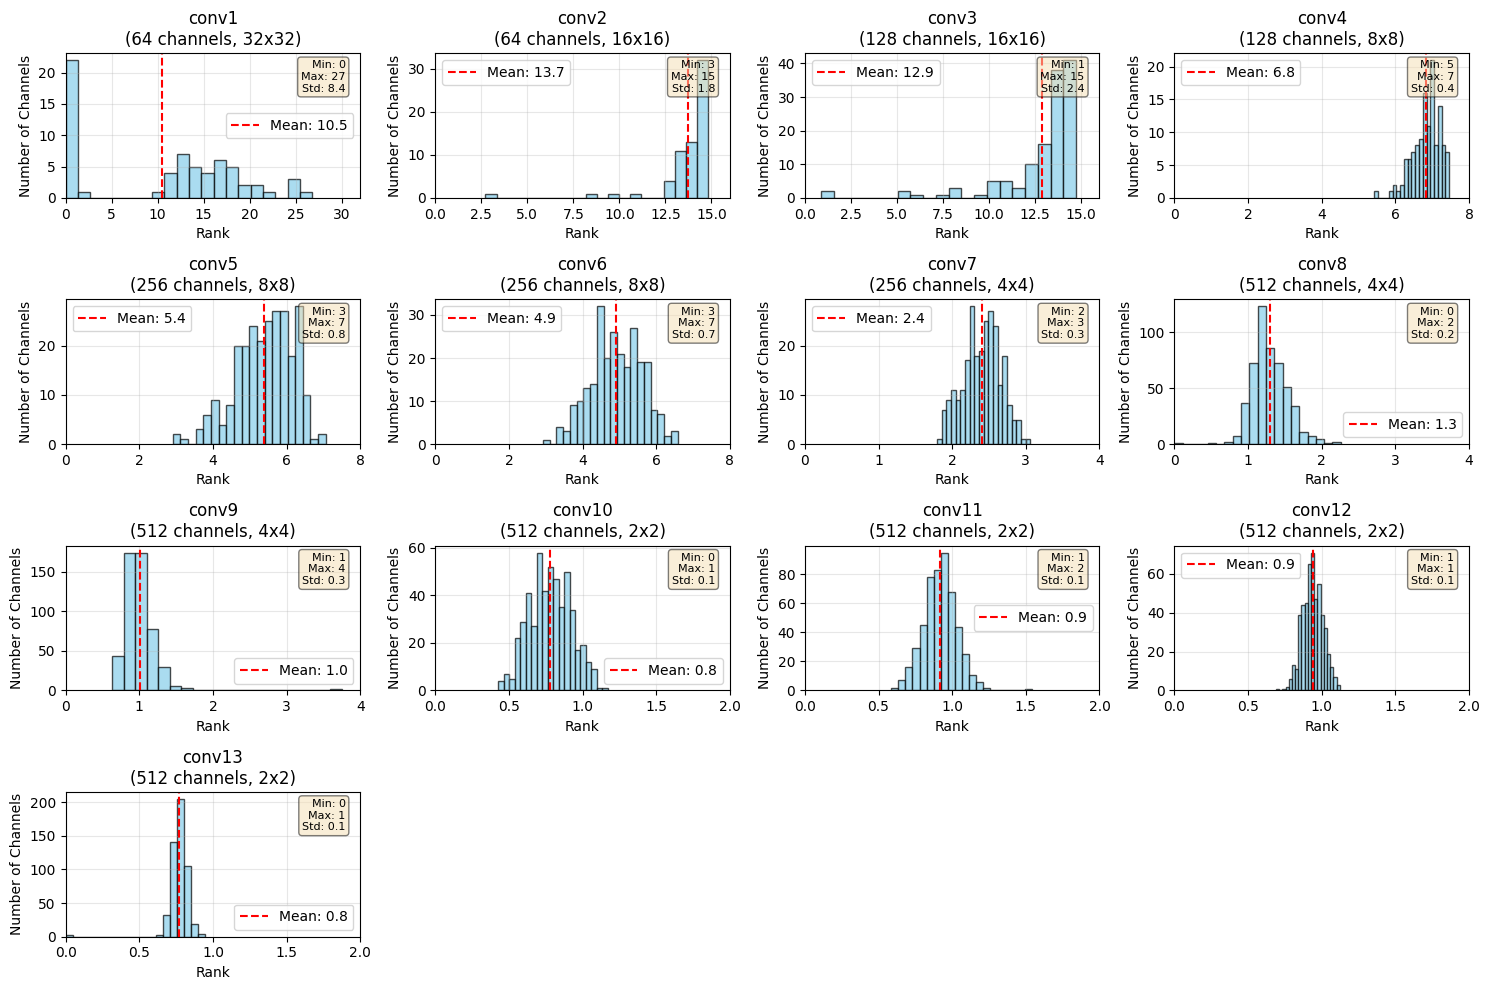

In [ ]:
# 랭크 계산 실행 스크립트
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")

all_ranks, layer_info = test_hrank_implementation(model, test_loader, device, limit=5)

##3.프루닝 계획 함수

In [ ]:
# 필요한 라이브러리
from typing import Dict, List, Tuple

###함수

In [ ]:
#프루닝 계획
def determine_pruning_plan(all_ranks: Dict, pruning_ratios: List[float]):
    """
    HRank 기반 프루닝 계획 수립

    Args:
        all_ranks: 각 레이어별 랭크 정보 {'conv1': array, 'conv2': array, ...}
        pruning_ratios: 각 레이어별 프루닝 비율 [0.3, 0.5, 0.2, ...]

    Returns:
        pruning_plan: 각 레이어별 프루닝 계획
        new_channels: 프루닝 후 각 레이어의 채널 수
    """
    pruning_plan = {}
    new_channels = {}

    layer_names = list(all_ranks.keys())

    # 프루닝 비율 검증 및 조정
    if len(pruning_ratios) == 1:
        # 모든 레이어에 동일한 비율 적용
        pruning_ratios = pruning_ratios * len(layer_names)
        print(f"모든 레이어에 {pruning_ratios[0]*100:.1f}% 프루닝 비율 적용")
    elif len(pruning_ratios) != len(layer_names):
        raise ValueError(f"프루닝 비율 개수({len(pruning_ratios)})와 레이어 수({len(layer_names)})가 맞지 않습니다.")

    print("\n" + "="*70)
    print("HRank 기반 프루닝 계획 수립")
    print("="*70)

    total_original_channels = 0
    total_pruned_channels = 0

    for i, (layer_name, ranks) in enumerate(all_ranks.items()):
        ratio = pruning_ratios[i]
        original_channels = len(ranks)
        total_original_channels += original_channels

        if ratio > 0 and ratio < 1.0:
            # 낮은 랭크 순으로 정렬하여 제거할 인덱스 선택
            num_to_prune = int(original_channels * ratio)
            # 최소 1개 채널은 유지
            num_to_prune = min(num_to_prune, original_channels - 1)

            # 랭크 기준으로 정렬 (낮은 랭크부터)
            sorted_indices = np.argsort(ranks)
            prune_indices = sorted_indices[:num_to_prune]
            keep_indices = sorted_indices[num_to_prune:]

            # 프루닝 계획 저장
            pruning_plan[layer_name] = {
                'prune_indices': prune_indices.tolist(),
                'keep_indices': keep_indices.tolist(),
                'original_channels': original_channels,
                'pruned_channels': len(keep_indices),
                'pruning_ratio_actual': len(prune_indices) / original_channels,
                'pruning_ratio_target': ratio,
                'pruned_ranks': ranks[prune_indices],  # 제거될 채널들의 랭크
                'kept_ranks': ranks[keep_indices]      # 유지될 채널들의 랭크
            }

            new_channels[layer_name] = len(keep_indices)
            total_pruned_channels += len(keep_indices)

        elif ratio >= 1.0:
            print(f"경고: {layer_name}의 프루닝 비율이 1.0 이상입니다. 프루닝하지 않습니다.")
            keep_indices = list(range(original_channels))
            pruning_plan[layer_name] = {
                'prune_indices': [],
                'keep_indices': keep_indices,
                'original_channels': original_channels,
                'pruned_channels': original_channels,
                'pruning_ratio_actual': 0.0,
                'pruning_ratio_target': ratio,
                'pruned_ranks': np.array([]),
                'kept_ranks': ranks
            }
            new_channels[layer_name] = original_channels
            total_pruned_channels += original_channels

        else:
            # 프루닝하지 않음 (ratio == 0)
            keep_indices = list(range(original_channels))
            pruning_plan[layer_name] = {
                'prune_indices': [],
                'keep_indices': keep_indices,
                'original_channels': original_channels,
                'pruned_channels': original_channels,
                'pruning_ratio_actual': 0.0,
                'pruning_ratio_target': ratio,
                'pruned_ranks': np.array([]),
                'kept_ranks': ranks
            }
            new_channels[layer_name] = original_channels
            total_pruned_channels += original_channels

        # 결과 출력
        plan = pruning_plan[layer_name]
        print(f"{layer_name:>6}: {plan['original_channels']:>3} -> {plan['pruned_channels']:>3} 채널 "
              f"({plan['pruning_ratio_actual']*100:>5.1f}% 프루닝)")

        if len(plan['prune_indices']) > 0:
            print(f"        제거될 채널 랭크 범위: {plan['pruned_ranks'].min():.1f} ~ {plan['pruned_ranks'].max():.1f}")
            print(f"        유지될 채널 랭크 범위: {plan['kept_ranks'].min():.1f} ~ {plan['kept_ranks'].max():.1f}")

    # 전체 요약
    overall_pruning_ratio = 1 - (total_pruned_channels / total_original_channels)
    print(f"\n전체 요약:")
    print(f"  총 원본 채널 수: {total_original_channels}")
    print(f"  총 프루닝 후 채널 수: {total_pruned_channels}")
    print(f"  전체 프루닝 비율: {overall_pruning_ratio*100:.1f}%")

    return pruning_plan, new_channels

###보조함수

In [ ]:
#----------------------------보조 함수--------------------------------------------

def visualize_pruning_plan(all_ranks: Dict, pruning_plan: Dict, layer_info: Dict, save_path=None):
    """프루닝 계획 시각화"""
    num_layers = len(all_ranks)

    if num_layers <= 4:
        rows, cols = 2, 2
    elif num_layers <= 6:
        rows, cols = 2, 3
    else:
        rows, cols = 3, (num_layers + 2) // 3

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    if num_layers == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, (layer_name, ranks) in enumerate(all_ranks.items()):
        if idx >= len(axes):
            break

        ax = axes[idx]
        plan = pruning_plan[layer_name]
        info = layer_info.get(layer_name, {})

        # 전체 랭크 히스토그램
        ax.hist(ranks, bins=20, alpha=0.3, color='gray', label='All channels', density=True)

        # 제거될 채널들의 랭크
        if len(plan['pruned_ranks']) > 0:
            ax.hist(plan['pruned_ranks'], bins=15, alpha=0.7, color='red',
                    label=f'Pruned ({len(plan["pruned_ranks"])})', density=True)

        # 유지될 채널들의 랭크
        if len(plan['kept_ranks']) > 0:
            ax.hist(plan['kept_ranks'], bins=15, alpha=0.7, color='blue',
                    label=f'Kept ({len(plan["kept_ranks"])})', density=True)

        # Feature map 크기 추가
        fm_size = f"{info.get('height', '?')}x{info.get('width', '?')}"
        ax.set_title(f'{layer_name} ({fm_size})\n{plan["original_channels"]} -> {plan["pruned_channels"]} '
                    f'({plan["pruning_ratio_actual"]*100:.1f}%)')

        ax.set_xlabel('Rank')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # X축 범위 고정
        max_possible_rank = info.get('max_possible_rank', ranks.max())
        ax.set_xlim(0, max_possible_rank)

    # 빈 subplot 숨기기
    for idx in range(len(all_ranks), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"프루닝 계획 시각화가 {save_path}에 저장되었습니다.")

    plt.show()

def validate_pruning_plan(pruning_plan: Dict):
    """프루닝 계획 검증"""
    print("\n프루닝 계획 검증 중...")

    validation_passed = True

    for layer_name, plan in pruning_plan.items():
        # 인덱스 중복 검사
        prune_set = set(plan['prune_indices'])
        keep_set = set(plan['keep_indices'])

        if prune_set & keep_set:  # 교집합이 있으면
            print(f"오류: {layer_name}에서 제거/유지 인덱스가 중복됩니다.")
            validation_passed = False

        # 전체 인덱스 검사
        all_indices = set(range(plan['original_channels']))
        plan_indices = prune_set | keep_set

        if all_indices != plan_indices:
            print(f"오류: {layer_name}에서 인덱스가 누락되거나 초과됩니다.")
            validation_passed = False

        # 최소 채널 수 검사
        if plan['pruned_channels'] < 1:
            print(f"오류: {layer_name}에서 유지되는 채널이 없습니다.")
            validation_passed = False

    if validation_passed:
        print("프루닝 계획 검증 통과!")
    else:
        print("프루닝 계획에 오류가 있습니다.")

    return validation_passed


def test_pruning_planner(all_ranks, pruning_ratios, state_dict=None):

    print("="*60)
    print("HRank 프루닝 계획 수립 테스트")
    print("="*60)

    # 1. Conv 레이어 프루닝 계획 수립
    pruning_plan, new_channels = determine_pruning_plan(all_ranks, pruning_ratios)

    # 2. 계획 검증
    is_valid = validate_pruning_plan(pruning_plan)

    # 3. 시각화
    if is_valid:
        visualize_pruning_plan(all_ranks, pruning_plan, layer_info, save_path='pruning_plan.png')

    return pruning_plan, new_channels, is_valid

###실행

In [ ]:
# pruning_ratios_0_7 = [0.7]

# pruning_plan_0_7, new_channels_0_7, is_valid_0_7 = test_pruning_planner(
#     all_ranks=all_ranks,
#     pruning_ratios=pruning_ratios_0_7,
#     state_dict=state_dict,)


In [ ]:
# pruning_ratios_0_6 = [0.6]

# pruning_plan_0_6, new_channels_0_6, is_valid_0_6 = test_pruning_planner(
#     all_ranks=all_ranks,
#     pruning_ratios=pruning_ratios_0_6,
#     state_dict=state_dict)

In [ ]:
# pruning_ratios_0_5 = [0.5]

# pruning_plan_0_5, new_channels_0_5, is_valid_0_5 = test_pruning_planner(
#     all_ranks=all_ranks,
#     pruning_ratios=pruning_ratios_0_5,
#     state_dict=state_dict,)

In [ ]:
# pruning_ratios_0_3 = [0.3]

# pruning_plan_0_3, new_channels_0_3,is_valid_0_3 = test_pruning_planner(
#     all_ranks=all_ranks,
#     pruning_ratios=pruning_ratios_0_3,
#     state_dict=state_dict)

##4.프루닝 블록

In [ ]:
#필요한 라이브러리
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
# 파인튜닝 용도 데이터셋
train_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2)
print("데이터 준비 완료!")

데이터 준비 완료!


###함수

In [ ]:
def prune_vgg16_only(orig_pt: str,
                     pruning_plan: dict,
                     num_classes=100,
                     save_path='vgg16_pruned.pth',
                     device=None):
    """
    VGG16_BN 모델을 프루닝만 수행 (fine-tuning 없음)
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 모델 생성
    model = vgg16_bn(weights=None)
    model.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))
    model.classifier = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(512, num_classes))
    model = model.to(device)

    # 원본 가중치 로드
    ckpt = torch.load(orig_pt, map_location=device, weights_only=False)
    if hasattr(ckpt, 'state_dict'):
        state_dict = ckpt.state_dict()
    else:
        state_dict = ckpt

    # features 로드
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('features.'):
            new_state_dict[k] = v
    model.load_state_dict(new_state_dict, strict=False)

    # Conv 레이어 인덱스
    conv_indices = []
    bn_indices = []
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d):
            conv_indices.append(i)
            bn_indices.append(i + 1)

    print("프루닝 시작...")

    # Conv 레이어 프루닝
    for i, conv_name in enumerate([f'conv{j+1}' for j in range(len(conv_indices))]):
        if conv_name not in pruning_plan:
            continue

        conv_idx = conv_indices[i]
        bn_idx = bn_indices[i]
        keep_indices = pruning_plan[conv_name]['keep_indices']

        # 출력 채널 프루닝
        old_conv = model.features[conv_idx]
        old_bn = model.features[bn_idx]

        new_conv = nn.Conv2d(
            old_conv.in_channels,
            len(keep_indices),
            kernel_size=3,
            padding=1,
            bias=(old_conv.bias is not None)
        )
        new_conv.weight.data = old_conv.weight.data[keep_indices].clone()
        if old_conv.bias is not None:
            new_conv.bias.data = old_conv.bias.data[keep_indices].clone()

        new_bn = nn.BatchNorm2d(len(keep_indices))
        new_bn.weight.data = old_bn.weight.data[keep_indices].clone()
        new_bn.bias.data = old_bn.bias.data[keep_indices].clone()
        new_bn.running_mean.data = old_bn.running_mean[keep_indices].clone()
        new_bn.running_var.data = old_bn.running_var[keep_indices].clone()

        model.features[conv_idx] = new_conv.to(device)
        model.features[bn_idx] = new_bn.to(device)

        # 다음 레이어 입력 조정
        if i < len(conv_indices) - 1:
            next_conv_idx = conv_indices[i + 1]
            next_conv = model.features[next_conv_idx]

            new_next_conv = nn.Conv2d(
                len(keep_indices),
                next_conv.out_channels,
                kernel_size=3,
                padding=1,
                bias=(next_conv.bias is not None)
            )
            new_next_conv.weight.data = next_conv.weight.data[:, keep_indices].clone()
            if next_conv.bias is not None:
                new_next_conv.bias.data = next_conv.bias.data.clone()
            model.features[next_conv_idx] = new_next_conv.to(device)

    # Classifier 재구성 및 가중치 이식
    model.eval() ###bn 파라미터 오염 방지
    dummy_input = torch.randn(1, 3, 32, 32, device=device)
    with torch.no_grad():
        features_output = model.features(dummy_input)
        flat_dim = features_output.view(1, -1).size(1)

    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(flat_dim, num_classes)
    ).to(device)

    # Classifier 가중치 이식
    if 'classifier.1.weight' in state_dict:
        orig_weight = state_dict['classifier.1.weight']
        orig_bias = state_dict['classifier.1.bias']

        last_conv_name = f'conv{len(conv_indices)}'
        if last_conv_name in pruning_plan:
            last_keep_indices = pruning_plan[last_conv_name]['keep_indices']
            keep_indices_tensor = torch.tensor(last_keep_indices, device=device)

            with torch.no_grad():
                model.classifier[1].weight.data = orig_weight[:, keep_indices_tensor].clone()
                model.classifier[1].bias.data = orig_bias.clone()
                print(f"Classifier 가중치 이식 완료: {orig_weight.size(1)} -> {flat_dim}")

    print("프루닝 완료!")

    # 모델 저장
    torch.save({
        'model_state_dict': model.state_dict(),
        'pruning_plan': pruning_plan
    }, save_path)

    print(f"모델 저장: {save_path}")
    return model




###실행


Remaining Ratio: 0.3 (Pruning Ratio: 0.7)
HRank 프루닝 계획 수립 테스트

HRank 기반 프루닝 계획 수립
 conv1:  64 ->  20 채널 ( 68.8% 프루닝)
        제거될 채널 랭크 범위: 0.0 ~ 15.7
        유지될 채널 랭크 범위: 16.1 ~ 26.8
 conv2:  64 ->  20 채널 ( 68.8% 프루닝)
        제거될 채널 랭크 범위: 2.7 ~ 14.4
        유지될 채널 랭크 범위: 14.4 ~ 14.8
 conv3: 128 ->  39 채널 ( 69.5% 프루닝)
        제거될 채널 랭크 범위: 0.9 ~ 14.1
        유지될 채널 랭크 범위: 14.1 ~ 14.7
 conv4: 128 ->  39 채널 ( 69.5% 프루닝)
        제거될 채널 랭크 범위: 5.4 ~ 7.0
        유지될 채널 랭크 범위: 7.0 ~ 7.5
 conv5: 256 ->  77 채널 ( 69.9% 프루닝)
        제거될 채널 랭크 범위: 2.9 ~ 5.9
        유지될 채널 랭크 범위: 5.9 ~ 7.1
 conv6: 256 ->  77 채널 ( 69.9% 프루닝)
        제거될 채널 랭크 범위: 2.9 ~ 5.3
        유지될 채널 랭크 범위: 5.3 ~ 6.6
 conv7: 256 ->  77 채널 ( 69.9% 프루닝)
        제거될 채널 랭크 범위: 1.8 ~ 2.5
        유지될 채널 랭크 범위: 2.5 ~ 3.1
 conv8: 512 -> 154 채널 ( 69.9% 프루닝)
        제거될 채널 랭크 범위: 0.0 ~ 1.4
        유지될 채널 랭크 범위: 1.4 ~ 2.3
 conv9: 512 -> 154 채널 ( 69.9% 프루닝)
        제거될 채널 랭크 범위: 0.6 ~ 1.1
        유지될 채널 랭크 범위: 1.1 ~ 3.8
conv10: 512 -> 15

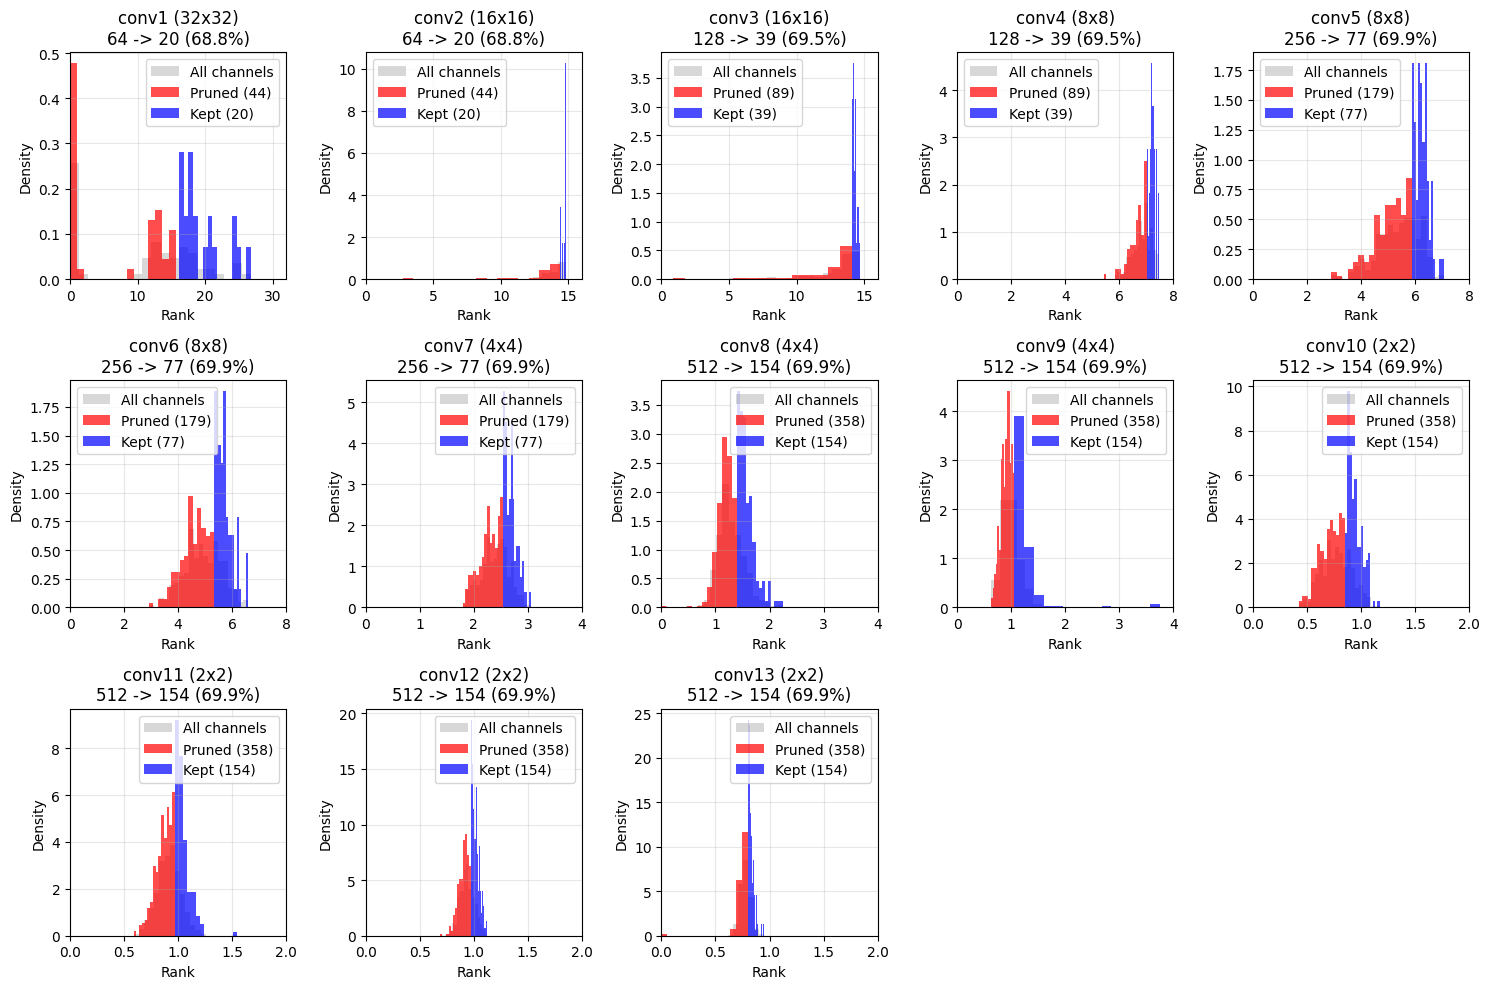

/usr/local/lib/python3.12/dist-packages/torch/serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


프루닝 시작...
Classifier 가중치 이식 완료: 512 -> 154
프루닝 완료!
모델 저장: vgg16_pruned_remaining_0.3.pth

Remaining Ratio: 0.4 (Pruning Ratio: 0.6)
HRank 프루닝 계획 수립 테스트

HRank 기반 프루닝 계획 수립
 conv1:  64 ->  26 채널 ( 59.4% 프루닝)
        제거될 채널 랭크 범위: 0.0 ~ 14.3
        유지될 채널 랭크 범위: 14.6 ~ 26.8
 conv2:  64 ->  26 채널 ( 59.4% 프루닝)
        제거될 채널 랭크 범위: 2.7 ~ 14.3
        유지될 채널 랭크 범위: 14.3 ~ 14.8
 conv3: 128 ->  52 채널 ( 59.4% 프루닝)
        제거될 채널 랭크 범위: 0.9 ~ 13.9
        유지될 채널 랭크 범위: 13.9 ~ 14.7
 conv4: 128 ->  52 채널 ( 59.4% 프루닝)
        제거될 채널 랭크 범위: 5.4 ~ 7.0
        유지될 채널 랭크 범위: 7.0 ~ 7.5
 conv5: 256 -> 103 채널 ( 59.8% 프루닝)
        제거될 채널 랭크 범위: 2.9 ~ 5.7
        유지될 채널 랭크 범위: 5.7 ~ 7.1
 conv6: 256 -> 103 채널 ( 59.8% 프루닝)
        제거될 채널 랭크 범위: 2.9 ~ 5.1
        유지될 채널 랭크 범위: 5.1 ~ 6.6
 conv7: 256 -> 103 채널 ( 59.8% 프루닝)
        제거될 채널 랭크 범위: 1.8 ~ 2.5
        유지될 채널 랭크 범위: 2.5 ~ 3.1
 conv8: 512 -> 205 채널 ( 60.0% 프루닝)
        제거될 채널 랭크 범위: 0.0 ~ 1.3
        유지될 채널 랭크 범위: 1.3 ~ 2.3
 conv9: 512 -> 205 채널 ( 60.

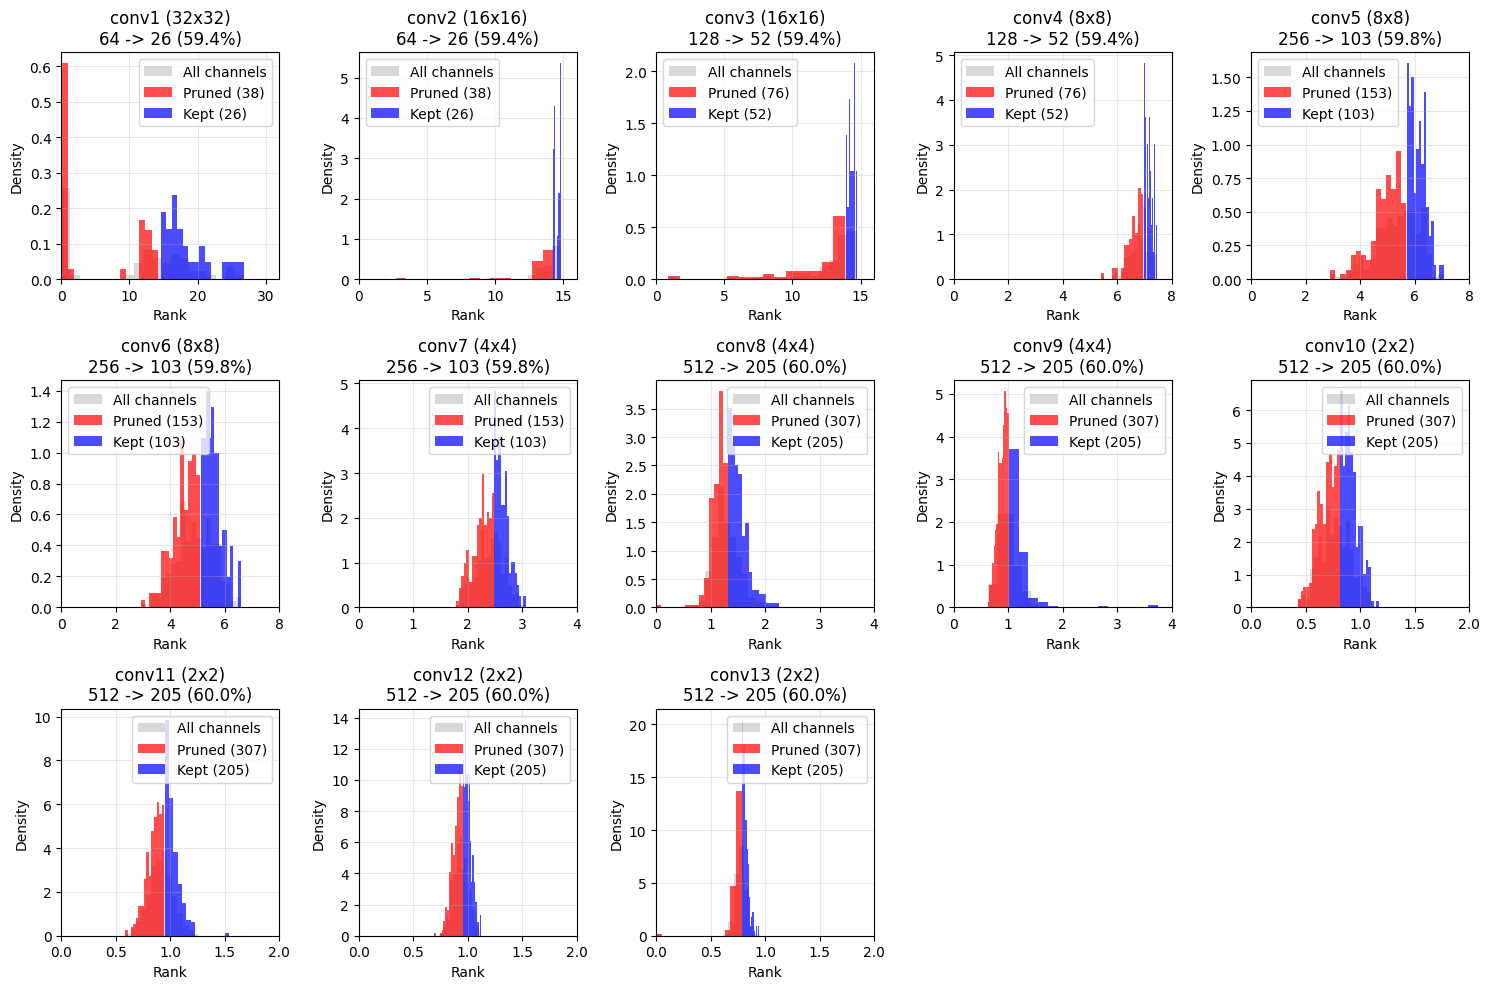

프루닝 시작...
Classifier 가중치 이식 완료: 512 -> 205
프루닝 완료!
모델 저장: vgg16_pruned_remaining_0.4.pth

Remaining Ratio: 0.5 (Pruning Ratio: 0.5)
HRank 프루닝 계획 수립 테스트

HRank 기반 프루닝 계획 수립
 conv1:  64 ->  32 채널 ( 50.0% 프루닝)
        제거될 채널 랭크 범위: 0.0 ~ 12.7
        유지될 채널 랭크 범위: 12.9 ~ 26.8
 conv2:  64 ->  32 채널 ( 50.0% 프루닝)
        제거될 채널 랭크 범위: 2.7 ~ 14.2
        유지될 채널 랭크 범위: 14.2 ~ 14.8
 conv3: 128 ->  64 채널 ( 50.0% 프루닝)
        제거될 채널 랭크 범위: 0.9 ~ 13.7
        유지될 채널 랭크 범위: 13.8 ~ 14.7
 conv4: 128 ->  64 채널 ( 50.0% 프루닝)
        제거될 채널 랭크 범위: 5.4 ~ 6.9
        유지될 채널 랭크 범위: 6.9 ~ 7.5
 conv5: 256 -> 128 채널 ( 50.0% 프루닝)
        제거될 채널 랭크 범위: 2.9 ~ 5.5
        유지될 채널 랭크 범위: 5.5 ~ 7.1
 conv6: 256 -> 128 채널 ( 50.0% 프루닝)
        제거될 채널 랭크 범위: 2.9 ~ 4.9
        유지될 채널 랭크 범위: 4.9 ~ 6.6
 conv7: 256 -> 128 채널 ( 50.0% 프루닝)
        제거될 채널 랭크 범위: 1.8 ~ 2.4
        유지될 채널 랭크 범위: 2.4 ~ 3.1
 conv8: 512 -> 256 채널 ( 50.0% 프루닝)
        제거될 채널 랭크 범위: 0.0 ~ 1.3
        유지될 채널 랭크 범위: 1.3 ~ 2.3
 conv9: 512 -> 256 채널 ( 50.

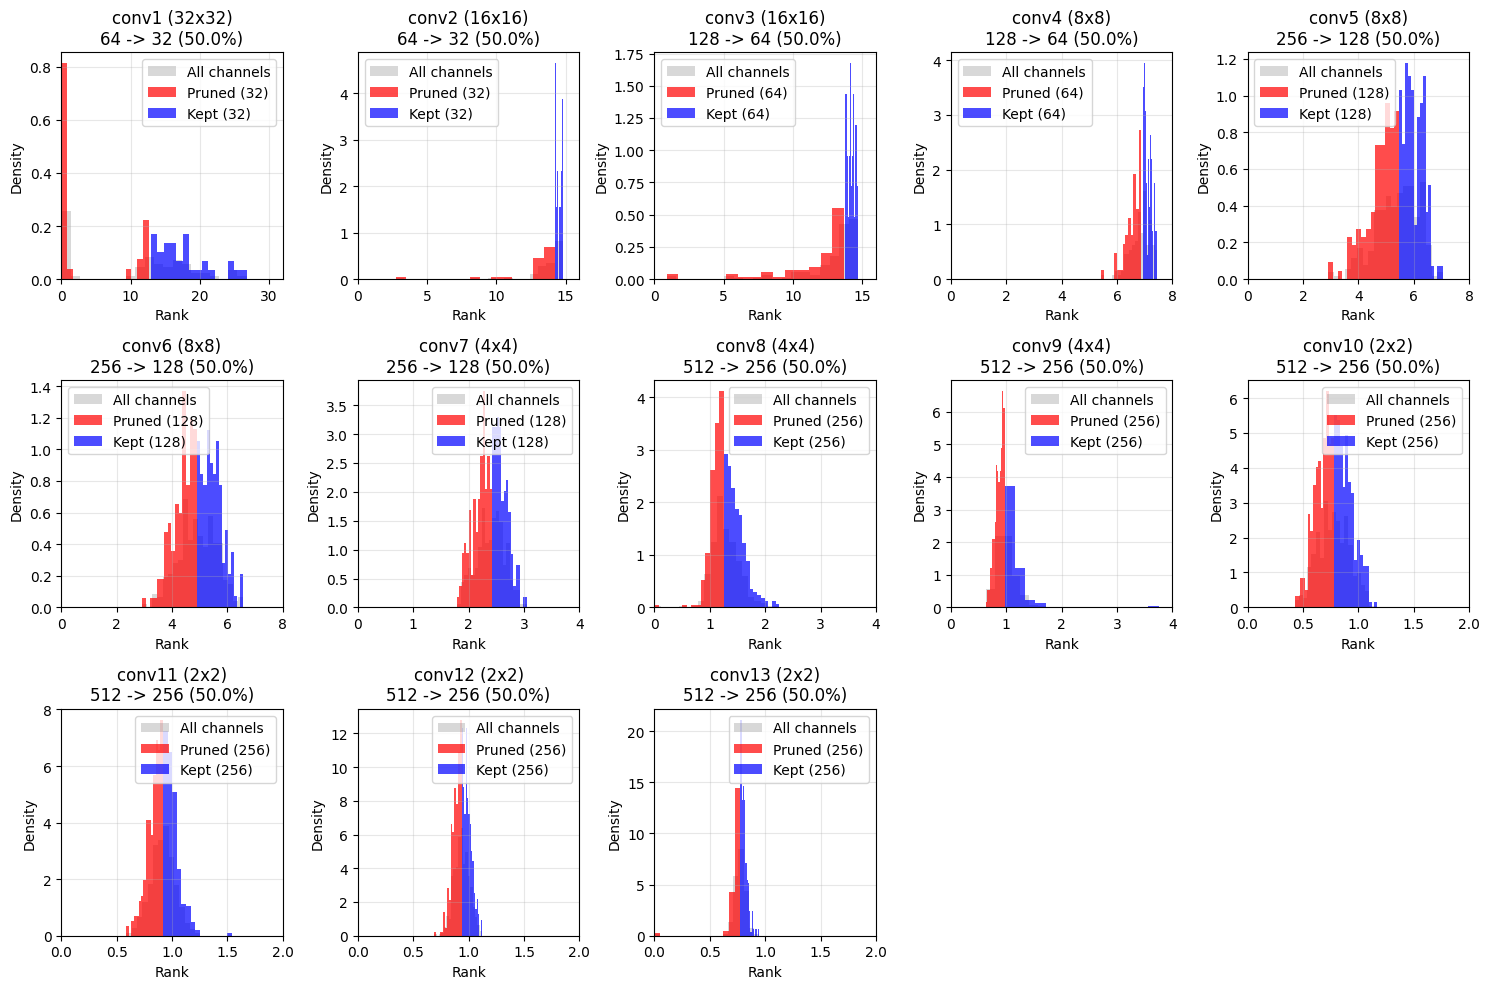

프루닝 시작...
Classifier 가중치 이식 완료: 512 -> 256
프루닝 완료!
모델 저장: vgg16_pruned_remaining_0.5.pth

Remaining Ratio: 0.7 (Pruning Ratio: 0.30000000000000004)
HRank 프루닝 계획 수립 테스트

HRank 기반 프루닝 계획 수립
 conv1:  64 ->  45 채널 ( 29.7% 프루닝)
        제거될 채널 랭크 범위: 0.0 ~ 0.0
        유지될 채널 랭크 범위: 0.0 ~ 26.8
 conv2:  64 ->  45 채널 ( 29.7% 프루닝)
        제거될 채널 랭크 범위: 2.7 ~ 13.5
        유지될 채널 랭크 범위: 13.8 ~ 14.8
 conv3: 128 ->  90 채널 ( 29.7% 프루닝)
        제거될 채널 랭크 범위: 0.9 ~ 13.1
        유지될 채널 랭크 범위: 13.1 ~ 14.7
 conv4: 128 ->  90 채널 ( 29.7% 프루닝)
        제거될 채널 랭크 범위: 5.4 ~ 6.7
        유지될 채널 랭크 범위: 6.7 ~ 7.5
 conv5: 256 -> 180 채널 ( 29.7% 프루닝)
        제거될 채널 랭크 범위: 2.9 ~ 5.0
        유지될 채널 랭크 범위: 5.0 ~ 7.1
 conv6: 256 -> 180 채널 ( 29.7% 프루닝)
        제거될 채널 랭크 범위: 2.9 ~ 4.5
        유지될 채널 랭크 범위: 4.5 ~ 6.6
 conv7: 256 -> 180 채널 ( 29.7% 프루닝)
        제거될 채널 랭크 범위: 1.8 ~ 2.3
        유지될 채널 랭크 범위: 2.3 ~ 3.1
 conv8: 512 -> 359 채널 ( 29.9% 프루닝)
        제거될 채널 랭크 범위: 0.0 ~ 1.2
        유지될 채널 랭크 범위: 1.2 ~ 2.3
 conv9: 512 -

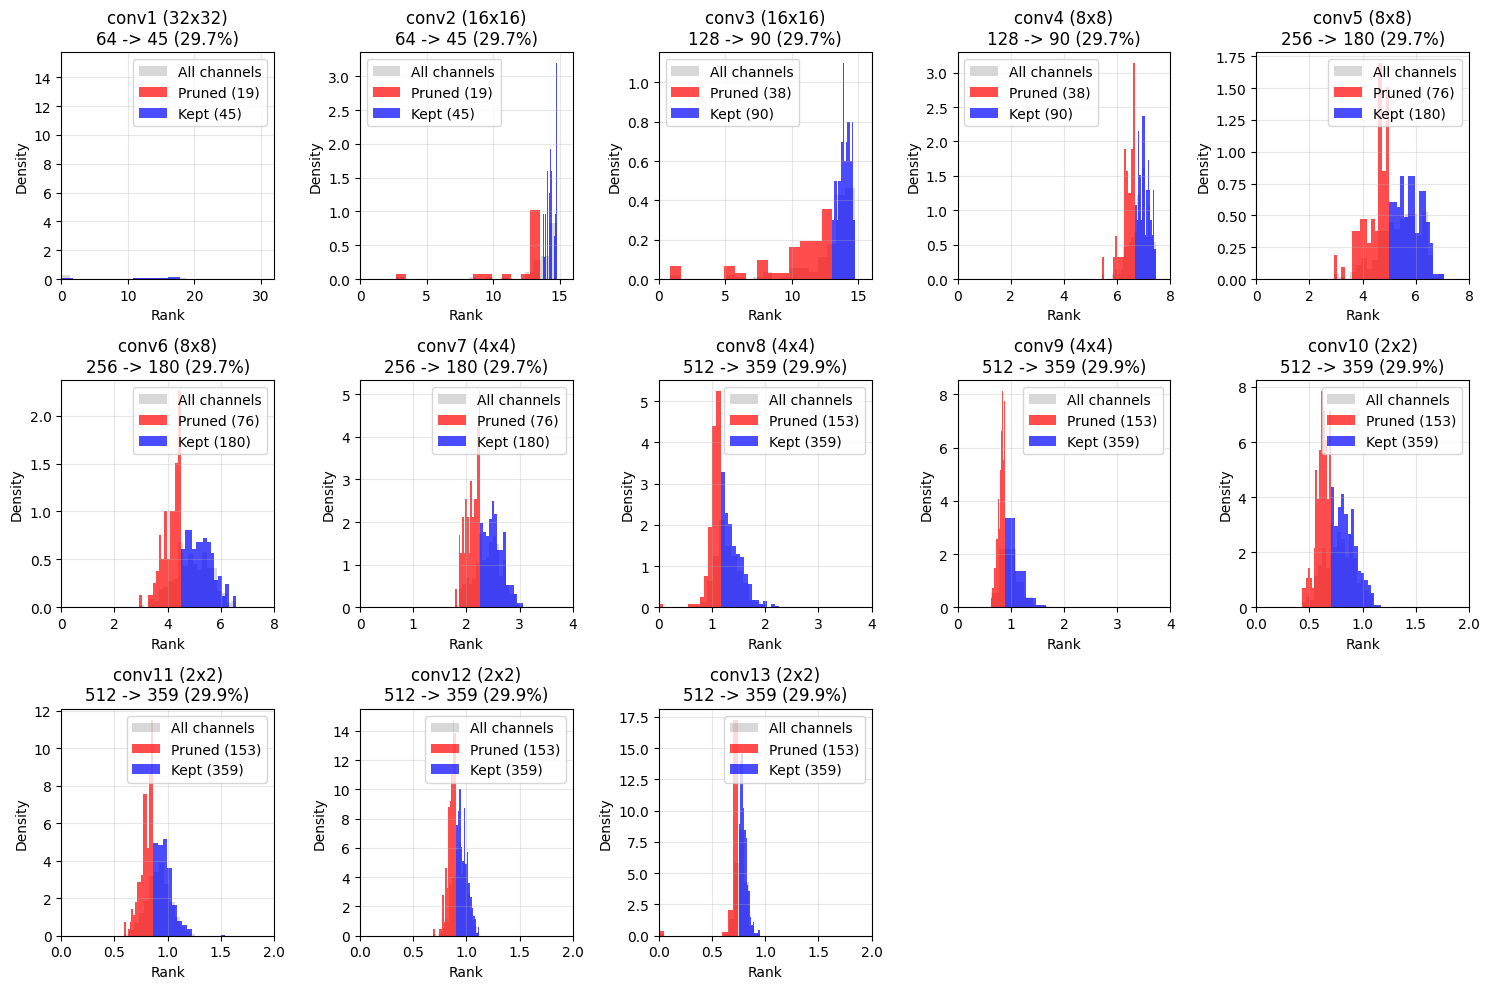

프루닝 시작...
Classifier 가중치 이식 완료: 512 -> 359
프루닝 완료!
모델 저장: vgg16_pruned_remaining_0.7.pth

모든 프루닝 완료!


In [ ]:
# 실행 코드
remaining_ratios = [0.3, 0.4, 0.5, 0.7]
pruned_models = {}

for remaining_ratio in remaining_ratios:
    pruning_ratio = 1 - remaining_ratio

    print(f"\n{'='*60}")
    print(f"Remaining Ratio: {remaining_ratio} (Pruning Ratio: {pruning_ratio})")
    print(f"{'='*60}")

    # 프루닝 계획 수립
    pruning_ratios = [pruning_ratio] * 13
    pruning_plan, new_channels,is_valid = test_pruning_planner(
        all_ranks=all_ranks,
        pruning_ratios=pruning_ratios,
        state_dict=state_dict)

    # 프루닝
    save_path = f'vgg16_pruned_remaining_{remaining_ratio}.pth'
    pruned_model = prune_vgg16_only(
        orig_pt='/content/vgg16bn_cifar100.torchscript.pt',
        pruning_plan=pruning_plan,
        num_classes=100,
        save_path=save_path)

    # 딕셔너리에 저장
    pruned_models[remaining_ratio] = pruned_model

print("\n모든 프루닝 완료!")

## 4.실행결과

In [ ]:
#프루닝 직후 정확도 평가
for remaining_ratio in remaining_ratios:
    pruning_ratio = 1 - remaining_ratio

    print(f"\n{'='*60}")
    print(f"Remaining Ratio: {remaining_ratio} (Pruning Ratio: {pruning_ratio})")
    print(f"{'='*60}")

    model_eval = pruned_models[remaining_ratio]
    model_eval.eval()
    summary(model_eval, input_size=(1,3,32,32), device=str(device))
    top1, top5 = evaluate(model_eval, test_loader, device)
    print(f"TorchScript Loaded → Top-1: {top1:.2f}%  Top-5: {top5:.2f}%")


Remaining Ratio: 0.3 (Pruning Ratio: 0.7)
TorchScript Loaded → Top-1: 1.08%  Top-5: 5.09%

Remaining Ratio: 0.4 (Pruning Ratio: 0.6)
TorchScript Loaded → Top-1: 1.02%  Top-5: 5.02%

Remaining Ratio: 0.5 (Pruning Ratio: 0.5)
TorchScript Loaded → Top-1: 1.04%  Top-5: 5.47%

Remaining Ratio: 0.7 (Pruning Ratio: 0.30000000000000004)
TorchScript Loaded → Top-1: 4.19%  Top-5: 13.88%
